# Feature Engineering

In machine learning, a feature is an individual measurable attribute of a phenomenon being observed. The extraction of features from raw training data is called *feature engineering*. In other words, feature engineering is a process of transforming raw training data into a *representation* suitable for the application of machine learning algorithms.

This process usually requires a certain degree of domain expertise and can be divided into the following stages <sup>[[1]](#ref_1)</sup>: 
- Brainstorming on features
- Deciding what features to create
- Creating features
- Studying how the features impact model's predictive accuracy
- Iterating if necessary

In [125]:
%matplotlib inline
import pyspark
from functools import reduce
from pyspark.sql import SparkSession, SQLContext, Window
import pyspark.sql.functions as F
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pyspark.storagelevel import StorageLevel

matplotlib.style.use('ggplot')

## Reading input data

In [126]:
sqlContext = SQLContext(sc)

df_telemetry = sqlContext.read.parquet('data/telemetry')
df_logs = sqlContext.read.parquet('data/logs')

df_telemetry.printSchema()
df_logs.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- ambient_pressure: double (nullable = true)
 |-- ambient_temperature: double (nullable = true)
 |-- machineID: string (nullable = true)
 |-- pressure: double (nullable = true)
 |-- speed: double (nullable = true)
 |-- speed_desired: long (nullable = true)
 |-- temperature: double (nullable = true)

root
 |-- timestamp: timestamp (nullable = true)
 |-- code: string (nullable = true)
 |-- level: string (nullable = true)
 |-- machineID: string (nullable = true)



In [127]:
print(df_telemetry.count())
print(df_logs.count())
df_logs.show()

4419266
8
+-------------------+----+--------+---------+
|          timestamp|code|   level|machineID|
+-------------------+----+--------+---------+
|2017-06-08 11:17:10|  F1|CRITICAL|   M_0506|
|2017-06-09 15:02:52|  F1|CRITICAL|   M_0144|
|2017-06-10 05:10:15|  F1|CRITICAL|   M_0942|
|2017-06-11 04:06:30|  F1|CRITICAL|   M_0709|
|2017-06-12 18:46:59|  F1|CRITICAL|   M_0998|
|2017-06-12 22:14:18|  F1|CRITICAL|   M_0217|
|2017-06-13 05:08:57|  F1|CRITICAL|   M_0174|
|2017-06-13 12:47:25|  F1|CRITICAL|   M_0030|
+-------------------+----+--------+---------+



## Data exploration

In [128]:
machineID = df_logs.first().machineID

machine_sequence_df = df_telemetry.where(df_telemetry.machineID == machineID).orderBy(df_telemetry.timestamp)
#machine_sequence_df.persist(StorageLevel.MEMORY_ONLY)
pdf = machine_sequence_df.toPandas()
pdf.set_index('timestamp', inplace=True)
pdf.describe()

,ambient_pressure,ambient_temperature,pressure,speed,speed_desired,temperature
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.0,5110.000000
mean,100.999162,20.000726,815.077857,999.818452,1000.0,156.985141
std,0.057630,0.057542,138.622522,8.558367,0.0,9.289316
min,100.900000,19.900000,160.790000,502.220000,1000.0,25.110000
25%,100.950000,19.950000,745.255000,997.462500,1000.0,151.150000
50%,101.000000,20.000000,855.025000,1000.020000,1000.0,154.405000
75%,101.050000,20.050000,921.257500,1002.570000,1000.0,160.210000
max,101.100000,20.100000,988.960000,1004.990000,1000.0,214.880000


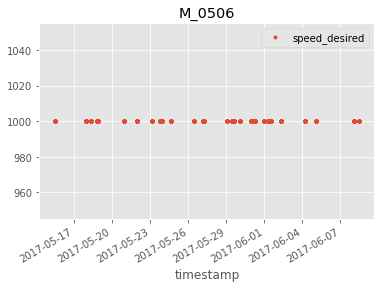

In [129]:
pdf.plot(title=machineID , style=".", y='speed_desired')

## Feature creation

### Operational cycles

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f01e24c7400>,
      dtype=object)

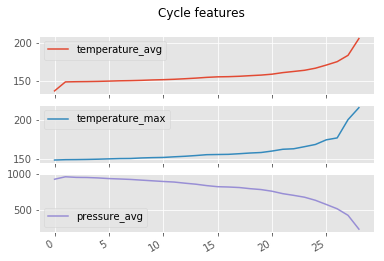

In [130]:
def cycles(df):
    w = Window.partitionBy('machineID').orderBy('timestamp')

    # Difference from the previous record or 0 if this is the first one
    diff = F.coalesce(F.unix_timestamp('timestamp') - F.unix_timestamp(F.lag('timestamp', 1).over(w)), F.lit(0))

    # 0 if diff <= 30, 1 otherwise
    indicator = (diff > 30).cast('integer')

    subgroup = F.sum(indicator).over(w).alias('cycle')

    return df.select("*", subgroup).groupBy('machineID', 'cycle').agg(
        F.avg('speed').alias('speed_avg'),
        F.avg('temperature').alias('temperature_avg'),
        F.max('temperature').alias('temperature_max'),
        F.avg('pressure').alias('pressure_avg'),
        F.min('timestamp').alias('cycle_start'),
        F.max('timestamp').alias('cycle_end')
    ).orderBy('cycle')

msdf_cycles = cycles(machine_sequence_df)
msdf_cycles[['temperature_avg', 'temperature_max', 'pressure_avg']].toPandas().plot(subplots=True, title='Cycle features')

In [131]:
cycles_df = cycles(df_telemetry)
# cycles_df.unpersist()
# cycles_df.persist(StorageLevel.MEMORY_AND_DISK)
cycles_df.count()

cycles_df.select(F.max(F.col('cycle_start'))).show()

+-------------------+
|   max(cycle_start)|
+-------------------+
|2017-06-14 15:57:00|
+-------------------+



### Augmenting data with additional lag features

In [132]:
w = Window.partitionBy('machineID').rowsBetween(-5, Window.currentRow).orderBy('cycle_start')
augmented_cycles_df = cycles_df.withColumn('rolling_average', F.avg("temperature_max").over(w))

### Labeling

In [133]:
#df_logs.show()

w = Window.partitionBy('machineID', 'level', 'code').orderBy('timestamp') # since last failure of the same type?
diff = F.coalesce(F.lag('timestamp', 1).over(w), F.to_timestamp(F.lit('2000-01-01 00:00:00')))

failures_df = (df_logs.where(df_logs.level == 'CRITICAL')
               .withColumn('last_failure_timestamp', diff)
               .withColumnRenamed('timestamp', 'failure_timestamp')
               .withColumnRenamed('code', 'failure')
               .drop('level'))

labeled_cycles_df = (augmented_cycles_df.join(failures_df,
                                       (augmented_cycles_df.machineID == failures_df.machineID) &
                                       (augmented_cycles_df.cycle_start >= failures_df.last_failure_timestamp) &
                                       (augmented_cycles_df.cycle_end <= failures_df.failure_timestamp),
                                       'left_outer')
                     .drop(failures_df.machineID)
                     .drop(augmented_cycles_df.cycle_end)
                     .drop(failures_df.last_failure_timestamp)
                     .withColumnRenamed('cycle_start', 'timestamp')
                     .withColumn(
                         'rul',
                         F.when(F.col('failure').isNull(), None).otherwise(
                             F.dense_rank().over(Window.partitionBy('machineID', 'failure_timestamp')
                                             .orderBy(F.desc('cycle')))))
                     .drop(failures_df.failure_timestamp))

In [134]:
labeled_cycles_df.limit(10).toPandas().head()

,machineID,cycle,speed_avg,temperature_avg,temperature_max,pressure_avg,timestamp,rolling_average,failure,rul
0,M_0217,33,1000.073406,187.673043,214.82,380.155580,2017-06-12 22:12:00,175.851667,F1,1
1,M_0217,32,999.677467,173.705233,179.67,541.218833,2017-06-12 05:02:00,166.905000,F1,2
2,M_0217,31,1000.136800,167.089667,169.64,634.847867,2017-06-10 07:20:00,163.550000,F1,3
3,M_0217,30,999.778167,164.637333,165.06,673.618667,2017-06-09 22:41:00,161.743333,F1,4
4,M_0217,29,999.911000,162.848400,164.36,702.745900,2017-06-09 07:11:00,160.541667,F1,5


In [135]:
labeled_cycles_df.where(labeled_cycles_df.failure.isNotNull()).groupBy('machineID').agg(F.max('rul')).toPandas().describe()

,max(rul)
count,8.00000
mean,30.25000
std,2.37547
min,28.00000
25%,28.75000
50%,29.00000
75%,32.25000
max,34.00000


## Persisting the labeled feature dataset

In [136]:
% rm -rf data/features

labeled_cycles_df.coalesce(5).write.csv('data/features', header=True)

## References
http://waset.org/publications/10006640/building-a-scalable-telemetry-based-multiclass-predictive-maintenance-model-in-r
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.386.8108&rep=rep1&type=pdf